In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt

In [2]:
dfs = []
for model_name in os.listdir('output'):
    dirname = os.path.join('output', model_name)
    model_tag, model_size, skip_rate = model_name.split('-')
    skip_rate = float(skip_rate)
    for filename in os.listdir(dirname):
        if filename.endswith('.csv'):
            filepath = os.path.join(dirname, filename)
            df = pd.read_csv(filepath)
            df = df.set_index('key')
            df.loc['skip', 'value'] = skip_rate
            df.loc['model_size', 'value'] = model_size 
            dfs.append(df)

In [3]:
dfs[0]

,value
key,
name,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...
skip,0.5
bandwidth,2.74727e+07
mem_limit,8589934592
allocation_strategy,BEST_FIT
eviction_strategy,LRU
total_time,328.982
idle_rate,0
compute_time,328.982


In [4]:
data = pd.concat(dfs, axis=1).T.reset_index()

In [5]:
for x in ['mem_limit', 'bandwidth', 'skip', 'total_time', 'idle_rate', 'h2d_time', 'd2h_time', 'duration(ms)']:
    data[x] = data[x].astype(float)

In [6]:
data['bandwidth'] = data['bandwidth'].apply(lambda x: round(x / 1024 / 1024, 2))
data['mem_limit'] = data['mem_limit'].apply(lambda x: round(x / 1024 / 1024 / 1024, 0))

In [7]:
data['bandwidth'].value_counts()

bandwidth
26.2    432
6.6     432
13.1    432
39.3    432
19.7    432
32.7    432
Name: count, dtype: int64

Does Stochastic Depth helps saving communication?

skip, bandwidth, mem_limit, -> total_time, idle_time 
with stochastic depth it saves more time than barely the computation. 

for each model size, plot a curve where the time/idle rate changes with the mem_limit/bandwidth


In [8]:
best_strategy_data = data.loc[data.groupby(['model_size', 'skip', 'bandwidth', 'mem_limit'])['total_time'].idxmin()]

In [9]:
best_strategy_data

key,index,name,skip,bandwidth,mem_limit,allocation_strategy,eviction_strategy,total_time,idle_rate,compute_time,h2d_time,d2h_time,duration(ms),model_size
2179,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,6.6,1.0,BEST_FIT,WEIGHTED_BELADY,6440.21,0.837941,6440.21,4.969260e+03,4.969260e+03,1051844.0,124M
2301,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,6.6,2.0,BEST_FIT,BELADY,1452.46,0.281428,1452.46,5.359980e+02,5.359980e+02,450476.0,124M
2195,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,6.6,4.0,BEST_FIT,WEIGHTED_BELADY,1043.69,0.000000,1043.69,8.224410e-317,0.000000e+00,400876.0,124M
2166,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,6.6,8.0,BEST_FIT,BELADY,1043.69,0.000000,1043.69,8.224410e-317,0.000000e+00,398159.0,124M
2161,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.0,6.6,12.0,BEST_FIT,WEIGHTED_LRU,1043.69,0.000000,1043.69,9.881313e-324,8.224410e-317,397378.0,124M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.5,39.3,2.0,BEST_FIT,WEIGHTED_LRU,4839.65,0.707628,4839.65,4.116140e+03,4.116140e+03,3370949.0,774M
249,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.5,39.3,4.0,BEST_FIT,WEIGHTED_BELADY,4391.50,0.677792,4391.5,3.084740e+03,3.084740e+03,11050565.0,774M
207,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.5,39.3,8.0,BEST_FIT,WEIGHTED_BELADY,2951.90,0.520656,2951.9,1.735650e+03,1.735650e+03,2441175.0,774M
196,value,/home/siyuanch/ssd/workspace_zelongg/dynet-dao...,0.5,39.3,12.0,BEST_FIT,WEIGHTED_BELADY,1621.02,0.127106,1621.02,3.726380e+02,3.726380e+02,1359915.0,774M


In [10]:
best_allocation_strategy = best_strategy_data['allocation_strategy'].value_counts()
best_eviction_strategy = best_strategy_data['eviction_strategy'].value_counts()
best_allocation_strategy, best_eviction_strategy

(allocation_strategy
 BEST_FIT    648
 Name: count, dtype: int64,
 eviction_strategy
 WEIGHTED_BELADY    286
 BELADY             141
 WEIGHTED_LRU       138
 LRU                 83
 Name: count, dtype: int64)

In [11]:
best_strategy_data['bandwidth'].value_counts()

bandwidth
6.6     108
13.1    108
19.7    108
26.2    108
32.7    108
39.3    108
Name: count, dtype: int64

In [61]:
from sklearn.linear_model import LinearRegression
import numpy as np 
from sklearn.metrics import r2_score 

def linear_regression(x, y):
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    # print('R2 score: ', r2)
    # print('Coefficients: ', model.coef_)
    # print('Intercept: ', model.intercept_)
    return int(model.coef_[0]), int(model.intercept_), round(r2,2)

In [78]:

def draw_with_fixed_metric(ax, ax1, target_metric, input_metric, fixed_metrics, normalized = False, prefix = 'a'):
    labelmap = {'mem_limit': 'GPU Mem (GB)', 'bandwidth': 'Bandwidth (MB/s)', 'total_time': 'Total Time (ms)', 'idle_rate': 'Idle Rate', 'h2d_time': 'H2D Time (ms)', 'd2h_time': 'D2H Time (ms)', 'duration(ms)': 'Duration (ms)', 'model_size': 'Model Size (MB)'}
    rows = None 
    for k, v in fixed_metrics.items():
        if rows is None: 
            rows = best_strategy_data[k] == v 
        else: 
            rows = rows & (best_strategy_data[k] == v)
    desired_data = best_strategy_data.loc[rows]
    lr_metrics = {}
    for name, group in desired_data.groupby(input_metric):
        lr_metric = linear_regression(group['skip'].values.reshape(-1, 1), group[target_metric])
        lr_metrics[name] = lr_metric
    desired_data = desired_data.set_index([input_metric, 'skip'])[target_metric].unstack().T 
    # print(desired_data.columns)
    if normalized: 
        desired_data /= desired_data.iloc[0]
    input_metrics = list(desired_data.columns)
    desired_data['GEOMEAN'] = desired_data.apply(lambda x: x.prod()**(1/len(x)), axis=1)
    print(desired_data['GEOMEAN'])
    desired_data = desired_data.T
    desired_data.plot.bar(ax=ax, rot=0)
    # ax.set_xlabel(labelmap[input_metric], fontsize=14)
    ax.set_xticks(ax.get_xticks(), [f'{metric}\nk: {lr_metrics[metric][0]}\nb: {lr_metrics[metric][1]}\nr2: {lr_metrics[metric][2]}' for metric in input_metrics] + ['GEOMEAN'])

    # ax1.plot(input_metrics, np.array(input_metrics) * k + b, label = 'pred')
    if input_metric == "bandwidth":
        k,b,r2 = linear_regression(1 / np.array(input_metrics).reshape(-1,1), [lr_metrics[metric][0] for metric in input_metrics])
        print('k', k, 'b', b, 'r2', r2)
        ax1.scatter(1 / np.array(input_metrics), [lr_metrics[metric][0] for metric in input_metrics])
        ax1.set_xlabel(f'1/{labelmap[input_metric]}', fontsize=14)
        ax1.plot(1 / np.array(input_metrics), 1 / np.array(input_metrics) * k + b, label = 'pred')
    else:
        k,b,r2 = linear_regression(np.array(input_metrics).reshape(-1,1), [lr_metrics[metric][0] for metric in input_metrics])
        print('k', k, 'b', b, 'r2', r2)
        ax1.scatter(input_metrics, [lr_metrics[metric][0] for metric in input_metrics]) 
        ax1.set_xlabel(labelmap[input_metric], fontsize=14)
        ax1.plot(input_metrics, np.array(input_metrics) * k + b, label = 'pred')
    ax1.legend()
    ax1.set_ylabel(f'd {labelmap[target_metric]}/d skip', fontsize=14)
    ax.set_ylabel(labelmap[target_metric], fontsize=14)
    title_str = ' '.join([f'{labelmap[k]}:{v}' for k, v in fixed_metrics.items()])
    ax.set_xlabel(f'{labelmap[input_metric]}\n{prefix}) {title_str}', fontsize=16)

skip
0.0    14246.033673
0.1    12391.196407
0.2    10026.672187
0.3     8532.258946
0.4     6724.733770
0.5     5076.550905
Name: GEOMEAN, dtype: float64
k -300429 b -2663 r2 1.0


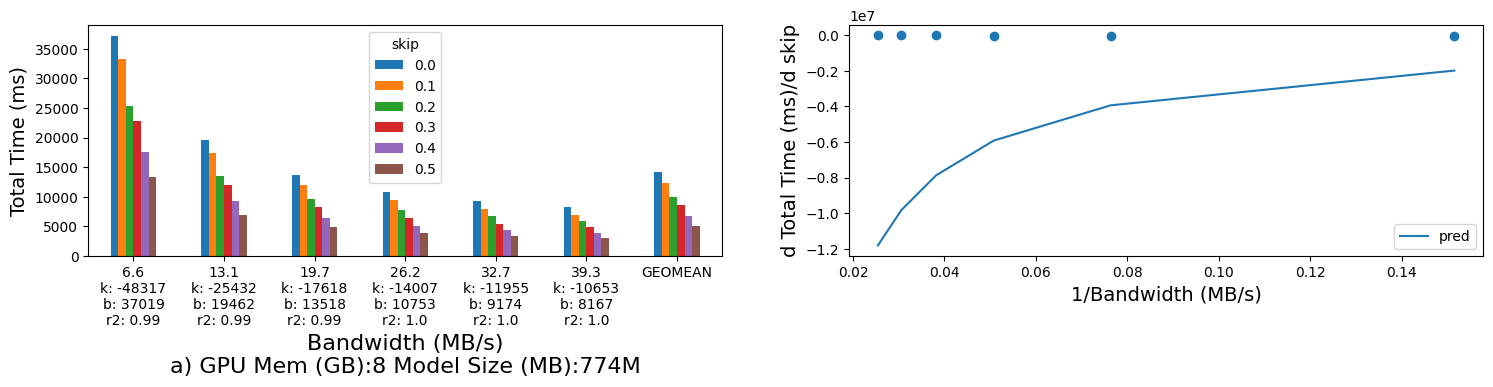

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(18, 3))
draw_with_fixed_metric(axes[0], axes[1],  'total_time', 'bandwidth', {'mem_limit':8, 'model_size':'774M'}, prefix = 'a')

skip
0.0    10927.289126
0.1     9323.423334
0.2     7789.518624
0.3     6428.333061
0.4     5118.806028
0.5     3845.678034
Name: GEOMEAN, dtype: float64
k 1154 b -23787 r2 0.99


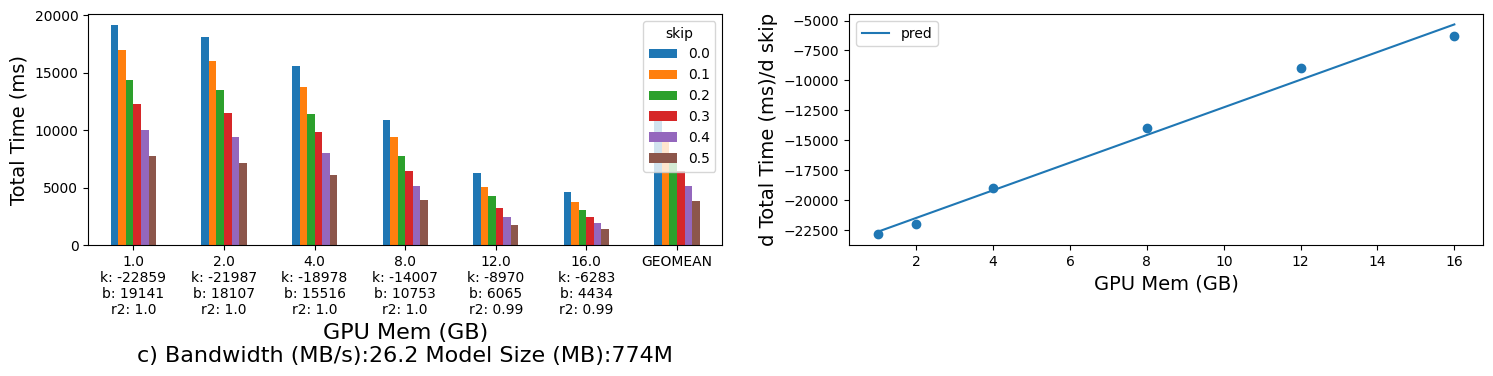

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(18, 3))
draw_with_fixed_metric(axes[0], axes[1], 'total_time', 'mem_limit', {'bandwidth':26.2, 'model_size':'774M'}, prefix = 'c')

Index([6.6, 13.1, 19.7, 26.2, 32.7, 39.3], dtype='float64', name='bandwidth')
skip
0.0    14246.033673
0.1    12391.196407
0.2    10026.672187
0.3     8532.258946
0.4     6724.733770
0.5     5076.550905
Name: GEOMEAN, dtype: float64
Index([6.6, 13.1, 19.7, 26.2, 32.7, 39.3], dtype='float64', name='bandwidth')
skip
0.0    0.622036
0.1    0.647928
0.2    0.648501
0.3    0.661634
0.4    0.667102
0.5    0.676456
Name: GEOMEAN, dtype: float64
Index([1.0, 2.0, 4.0, 8.0, 12.0, 16.0], dtype='float64', name='mem_limit')
skip
0.0    10927.289126
0.1     9323.423334
0.2     7789.518624
0.3     6428.333061
0.4     5118.806028
0.5     3845.678034
Name: GEOMEAN, dtype: float64
Index([1.0, 2.0, 4.0, 8.0, 12.0, 16.0], dtype='float64', name='mem_limit')
skip
0.0    0.265851
0.1    0.191144
0.2    0.000000
0.3    0.000000
0.4    0.000000
0.5    0.000000
Name: GEOMEAN, dtype: float64


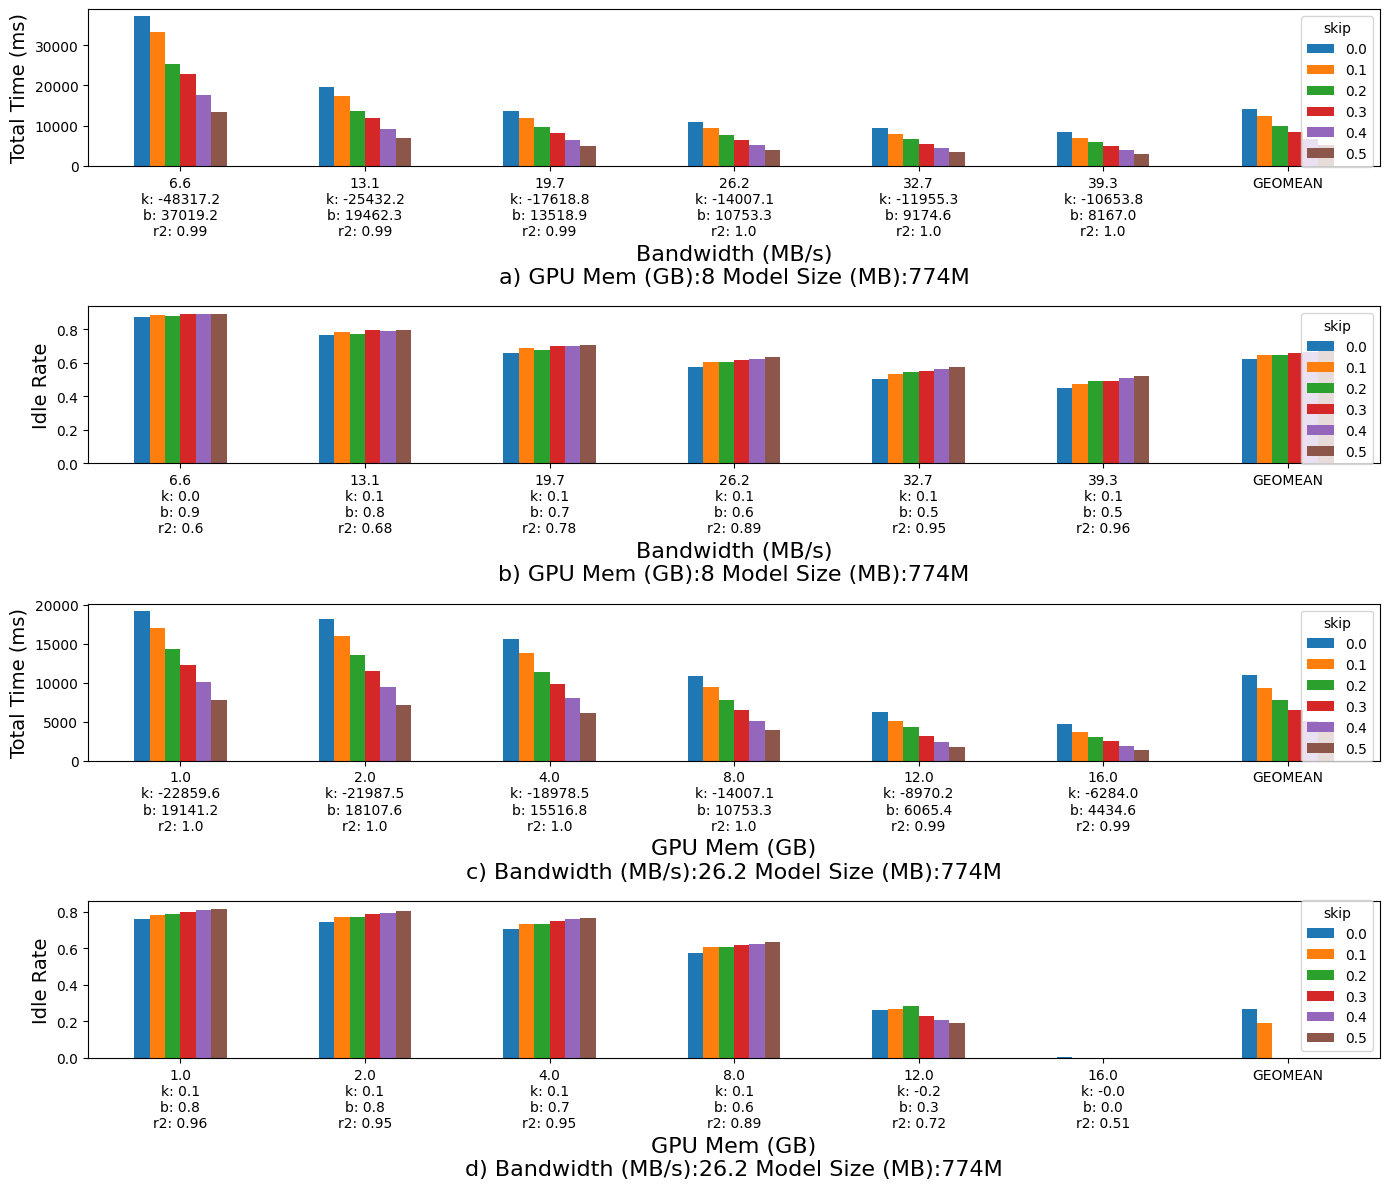

In [44]:
fig, axes = plt.subplots(4,2,figsize=(14,12), tight_layout=True)
draw_with_fixed_metric(axes[0], 'total_time', 'bandwidth', {'mem_limit':8, 'model_size':'774M'}, prefix = 'a')
draw_with_fixed_metric(axes[1], 'idle_rate', 'bandwidth', {'mem_limit':8, 'model_size':'774M'}, prefix = 'b')
draw_with_fixed_metric(axes[2], 'total_time', 'mem_limit', {'bandwidth':26.2, 'model_size':'774M'}, prefix = 'c')
draw_with_fixed_metric(axes[3], 'idle_rate', 'mem_limit', {'bandwidth':26.2, 'model_size':'774M'}, prefix = 'd')
# draw_with_fixed_metric(axes[4], 'total_time', 'model_size', {'mem_limit':8, 'bandwidth': 13.1}, prefix = 'e')
# draw_with_fixed_metric(axes[5], 'idle_rate', 'model_size', {'mem_limit':8, 'bandwidth': 26.2}, prefix = 'f')
fig.savefig('performance-skip.png')
fig.savefig('performance-skip.pdf')

Can we do a regression to predict the total time;
Model_size, e^(-a bandwidth) / gpu_mem_size  skip_rate -> total_time 

skip
0.0    0.009018
0.1    0.001027
0.2    0.000000
0.3    0.000000
0.4    0.000000
0.5    0.000000
Name: GEOMEAN, dtype: float64
skip
0.0    8.028128e+03
0.1    4.656761e+03
0.2    3.825174e-51
0.3    3.257472e-51
0.4    3.751970e-50
0.5    4.208460e-48
Name: GEOMEAN, dtype: float64
skip
0.0    0.0
0.1    0.0
0.2    0.0
0.3    0.0
0.4    0.0
0.5    0.0
Name: GEOMEAN, dtype: float64


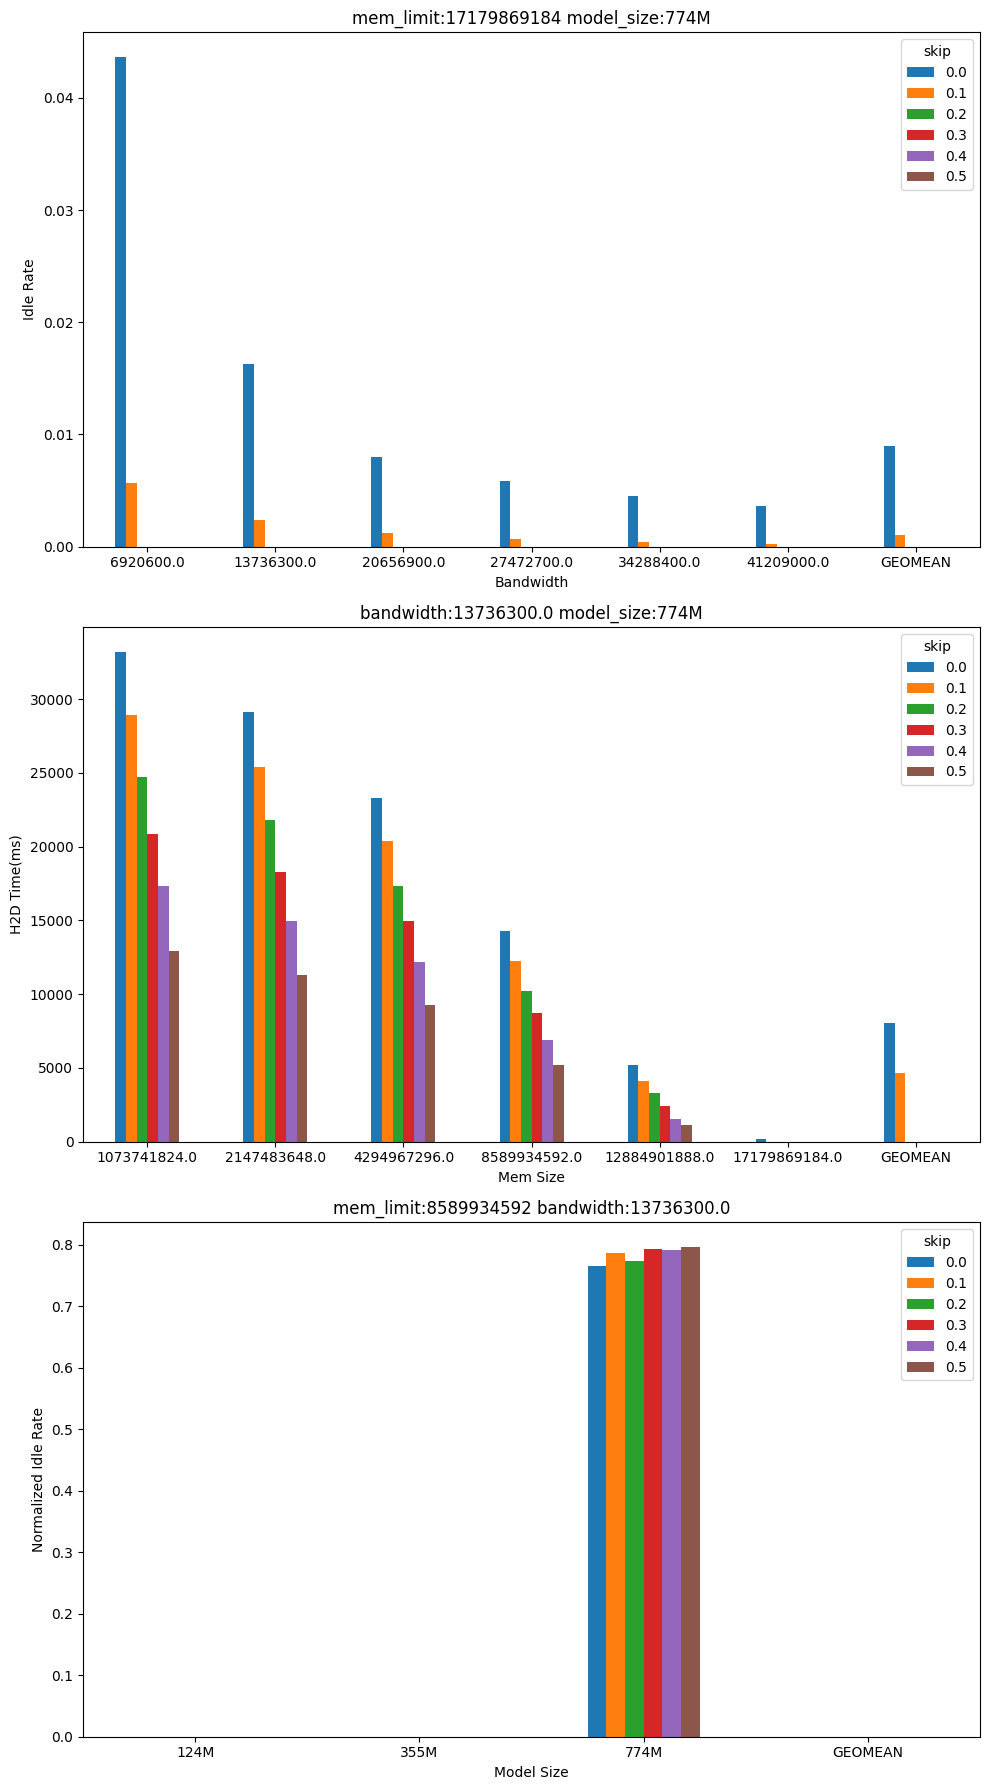

In [15]:
fig, axes = plt.subplots(3,1,figsize=(10,18), tight_layout=True)
draw_with_fixed_metric(axes[0], 'idle_rate', 'Idle Rate', 'bandwidth', 'Bandwidth', {'mem_limit':8*1073741824, 'model_size':'774M'}, )
draw_with_fixed_metric(axes[1], 'h2d_time', 'H2D Time(ms)', 'mem_limit', 'Mem Size', {'bandwidth':13736300.0, 'model_size':'774M'})
draw_with_fixed_metric(axes[2], 'idle_rate', 'Normalized Idle Rate', 'model_size', 'Model Size', {'mem_limit':8*1073741824, 'bandwidth': 13736300.0})

skip
0.0    10927.363240
0.1     9406.156364
0.2     7801.682063
0.3     6673.560196
0.4     5276.938993
0.5     3990.504238
Name: GEOMEAN, dtype: float64
skip
0.0    8.028128e+03
0.1    4.656761e+03
0.2    5.409613e-51
0.3    4.637270e-50
0.4    5.369311e-48
0.5    2.065771e-51
Name: GEOMEAN, dtype: float64
skip
0.0     1.000000e+00
0.1     0.000000e+00
0.2     0.000000e+00
0.3    2.225059e-106
0.4     0.000000e+00
0.5     0.000000e+00
Name: GEOMEAN, dtype: float64


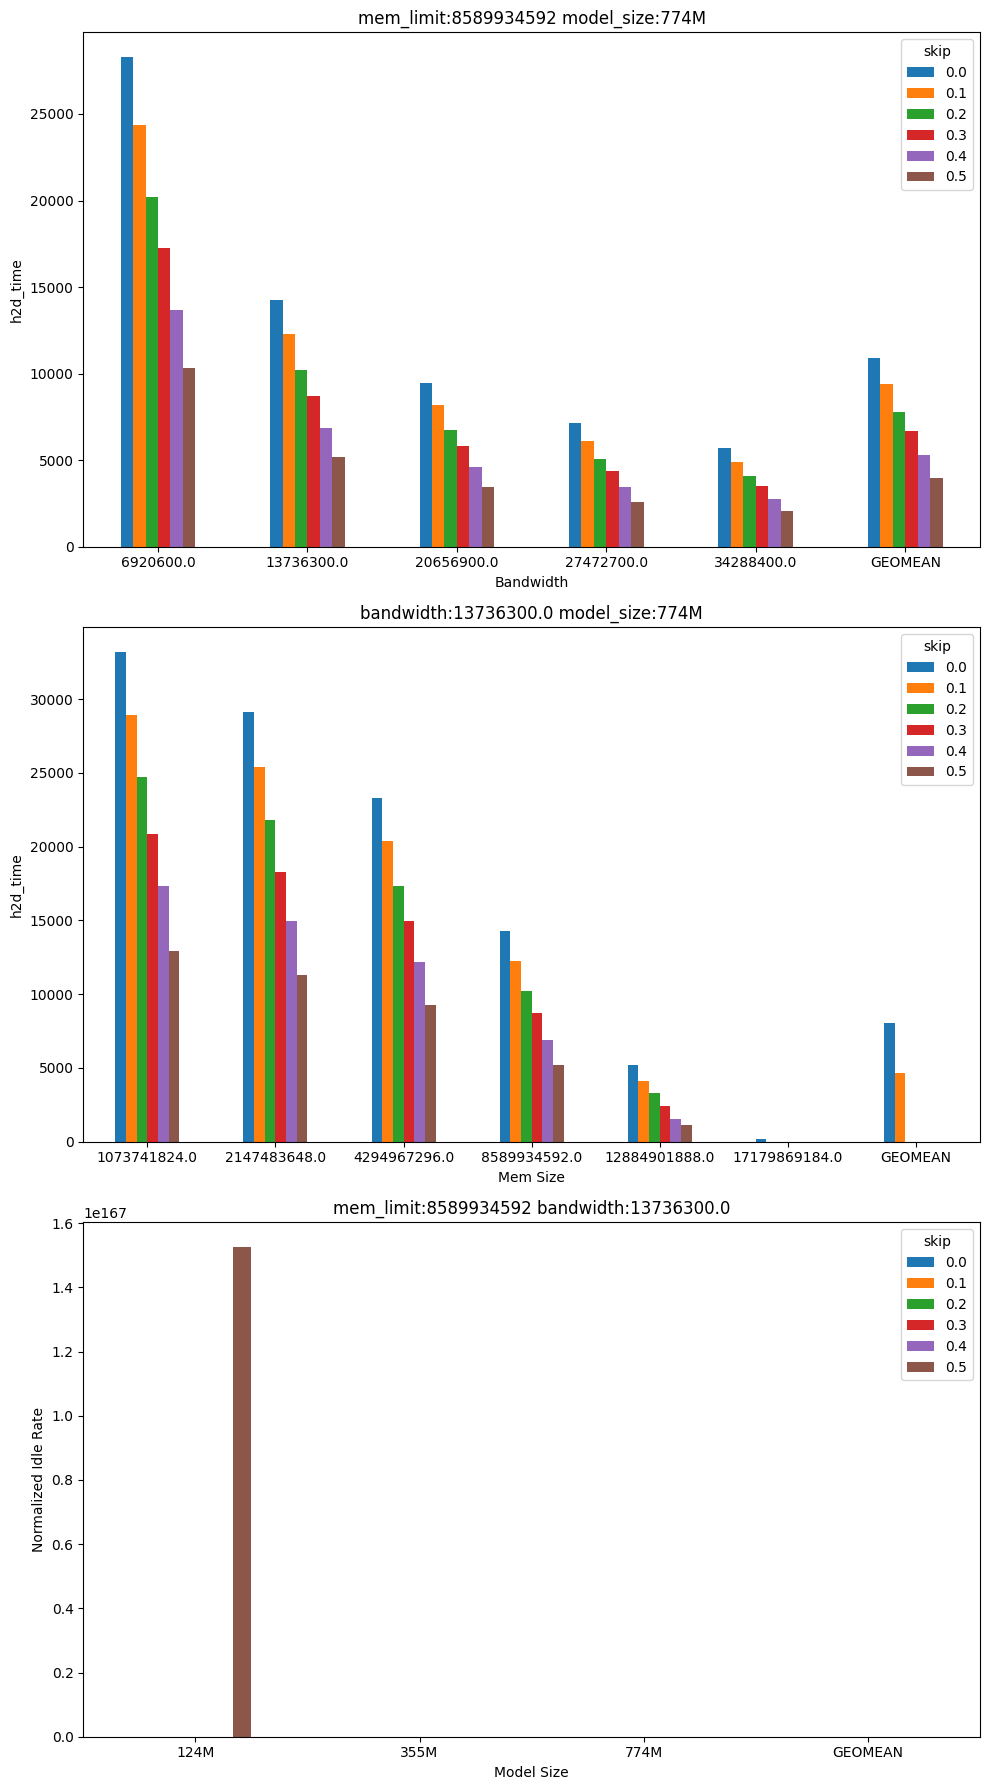

In [18]:
fig, axes = plt.subplots(3,1,figsize=(10,18), tight_layout=True)
draw_with_fixed_metric(axes[0], 'h2d_time', 'h2d_time', 'bandwidth', 'Bandwidth', {'mem_limit':8*1073741824, 'model_size':'774M'}, )
draw_with_fixed_metric(axes[1], 'h2d_time', 'h2d_time', 'mem_limit', 'Mem Size', {'bandwidth':13736300.0, 'model_size':'774M'})
draw_with_fixed_metric(axes[2], 'h2d_time', 'Normalized Idle Rate', 'model_size', 'Model Size', {'mem_limit':8*1073741824, 'bandwidth': 13736300.0}, normalized=True)

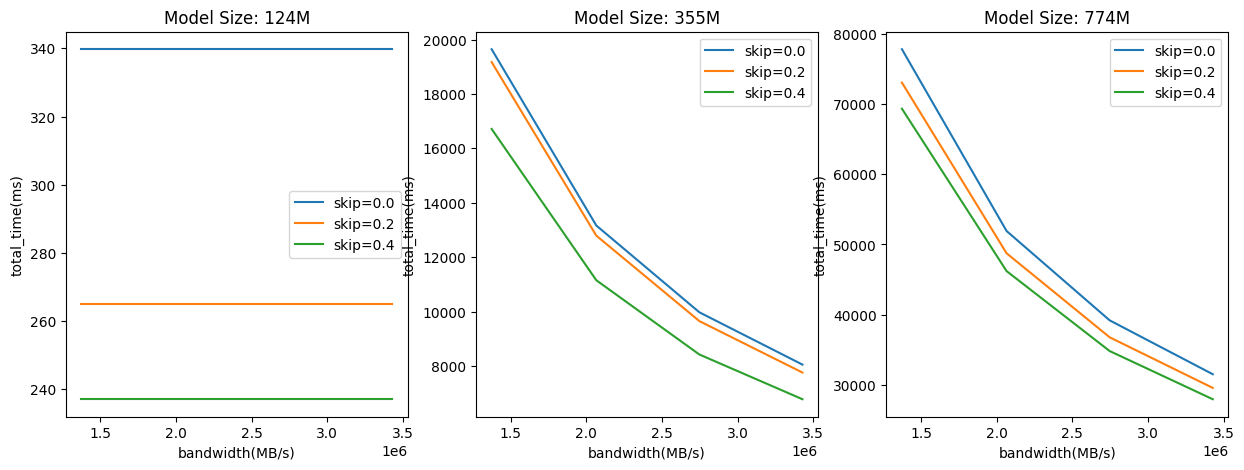

In [8]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
model_size2ax = {"124M": axes[0], "355M": axes[1], "774M": axes[2]}
for k, ax in model_size2ax.items():
    ax.set_title(f"Model Size: {k}")
for (model_size, skip_rate, mem_limit), group in best_strategy_data.groupby(['model_size', 'skip', 'mem_limit']):
    if mem_limit != 4*1073741824: continue 
    ax = model_size2ax[model_size]
    # try: 
        # Assuming 'group' is your DataFrame and 'bandwidth' is the column you want to plot
    sorted_group = group.sort_values('bandwidth')
    sorted_group.plot(ax=ax, x='bandwidth', y='total_time', label=f'skip={skip_rate}')
    ax.set_xlabel('bandwidth(MB/s)')
    ax.set_ylabel('total_time(ms)')
    # except:
    #     print('error')
    #     print(group)

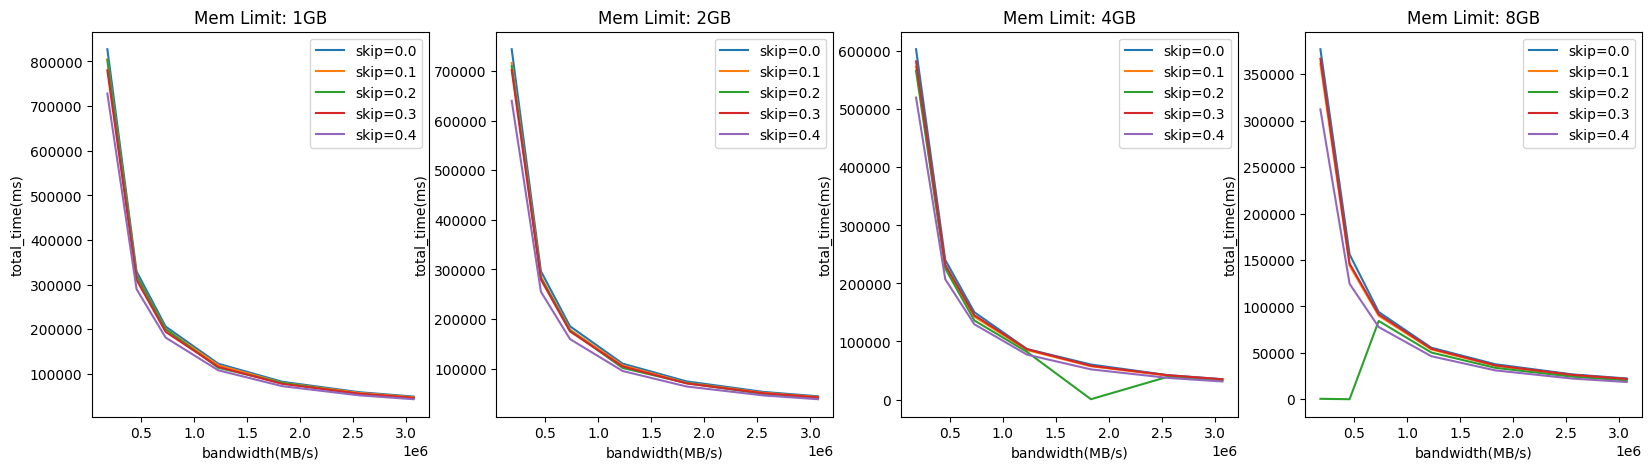

In [16]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
d = {1:0, 2:1, 4:2, 8:3}
mem_limit2ax = lambda x: axes[d[x //1073741824]]
for k, v in d.items():
    axes[v].set_title(f"Mem Limit: {k}GB")
    
for (model_size, skip_rate, mem_limit), group in best_strategy_data.groupby(['model_size', 'skip', 'mem_limit']):
    if model_size != '774M': continue 
    if mem_limit > 8*1073741824: continue
    ax = mem_limit2ax(mem_limit)
    try: 
        # Assuming 'group' is your DataFrame and 'bandwidth' is the column you want to plot
        sorted_group = group.sort_values('bandwidth')
        sorted_group.plot(ax=ax, x='bandwidth', y='total_time', label=f'skip={skip_rate}')
        ax.set_xlabel('bandwidth(MB/s)')
        ax.set_ylabel('total_time(ms)')
    except:
        print('error')
        print(group)

In [48]:
def draw_with_bw(ax, model_size = '774M', mem_limit = 8*1073741824):
    desired_data = best_strategy_data.loc[(best_strategy_data['model_size'] == model_size) & (best_strategy_data['mem_limit'] == mem_limit) & (best_strategy_data['bandwidth'] >= 715*1024)]
    desired_data['bandwidth'] = desired_data['bandwidth'].apply(lambda x: round(x/(1024**2), 3))
    tmp = desired_data.set_index(['bandwidth','skip'])['total_time'].unstack() 
    tmp = tmp.T 
    tmp['geomean'] = tmp.apply(lambda x: x.prod()**(1/len(x)), axis=1)
    tmp = tmp.T
    print(tmp.loc['geomean'])
    tmp.plot.bar(ax=ax, rot=45)
    ax.set_xlabel('Bandwidth(GB/s)')
    ax.set_ylabel('Total Time(ms)')
    ax.set_title(f'Model Size: {model_size}, Mem: {mem_limit/1073741824}GB')


In [49]:
def draw_with_mem_limit(ax, model_size, mem_bandwidth = 715*1024):
    desired_data = best_strategy_data.loc[(best_strategy_data['model_size'] == model_size) & (best_strategy_data['bandwidth'] == mem_bandwidth) & (best_strategy_data['mem_limit'] <= 8*1073741824)]
    desired_data['mem_limit'] = desired_data['mem_limit'].apply(lambda x: round(x/(1024**3), 0))
    tmp = desired_data.set_index(['mem_limit','skip'])['total_time'].unstack() 
    tmp = tmp.T 
    tmp['geomean'] = tmp.apply(lambda x: x.prod()**(1/len(x)), axis=1)
    tmp = tmp.T
    print(tmp.loc['geomean'])
    tmp.plot.bar(ax=ax, rot=45)
    ax.set_xlabel('mem_limit(GB)')
    ax.set_ylabel('total_time(ms)')
    ax.set_title(f"Model Size: {model_size}, Bandwidth: {mem_bandwidth/1024}MB/s")

/tmp/ipykernel_350264/1642564473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_data['mem_limit'] = desired_data['mem_limit'].apply(lambda x: round(x/(1024**3), 0))
/tmp/ipykernel_350264/530572976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired_data['bandwidth'] = desired_data['bandwidth'].apply(lambda x: round(x/(1024**2), 3))


skip
0.0    152482.916706
0.1    146494.000084
0.2    142078.758948
0.3    145801.688202
0.4    130746.926263
Name: geomean, dtype: float64
skip
0.0    41252.596050
0.1    39658.873454
0.2    37267.969832
0.3    40291.304916
0.4    34247.461658
Name: geomean, dtype: float64


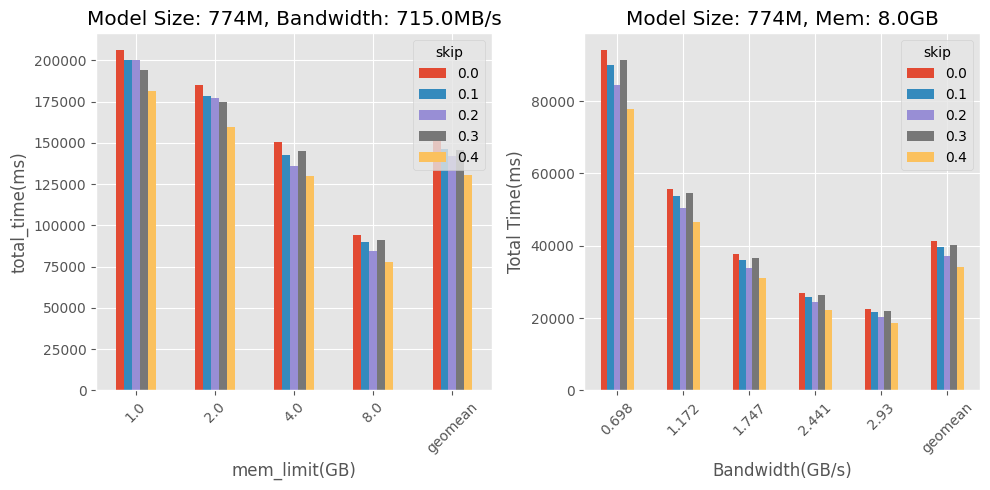

In [51]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2,figsize=(10,5), tight_layout=True)
draw_with_mem_limit(axes[0], '774M')
draw_with_bw(axes[1], '774M')
fig.savefig('skip_rate.pdf')
fig.savefig('skip_rate.png')

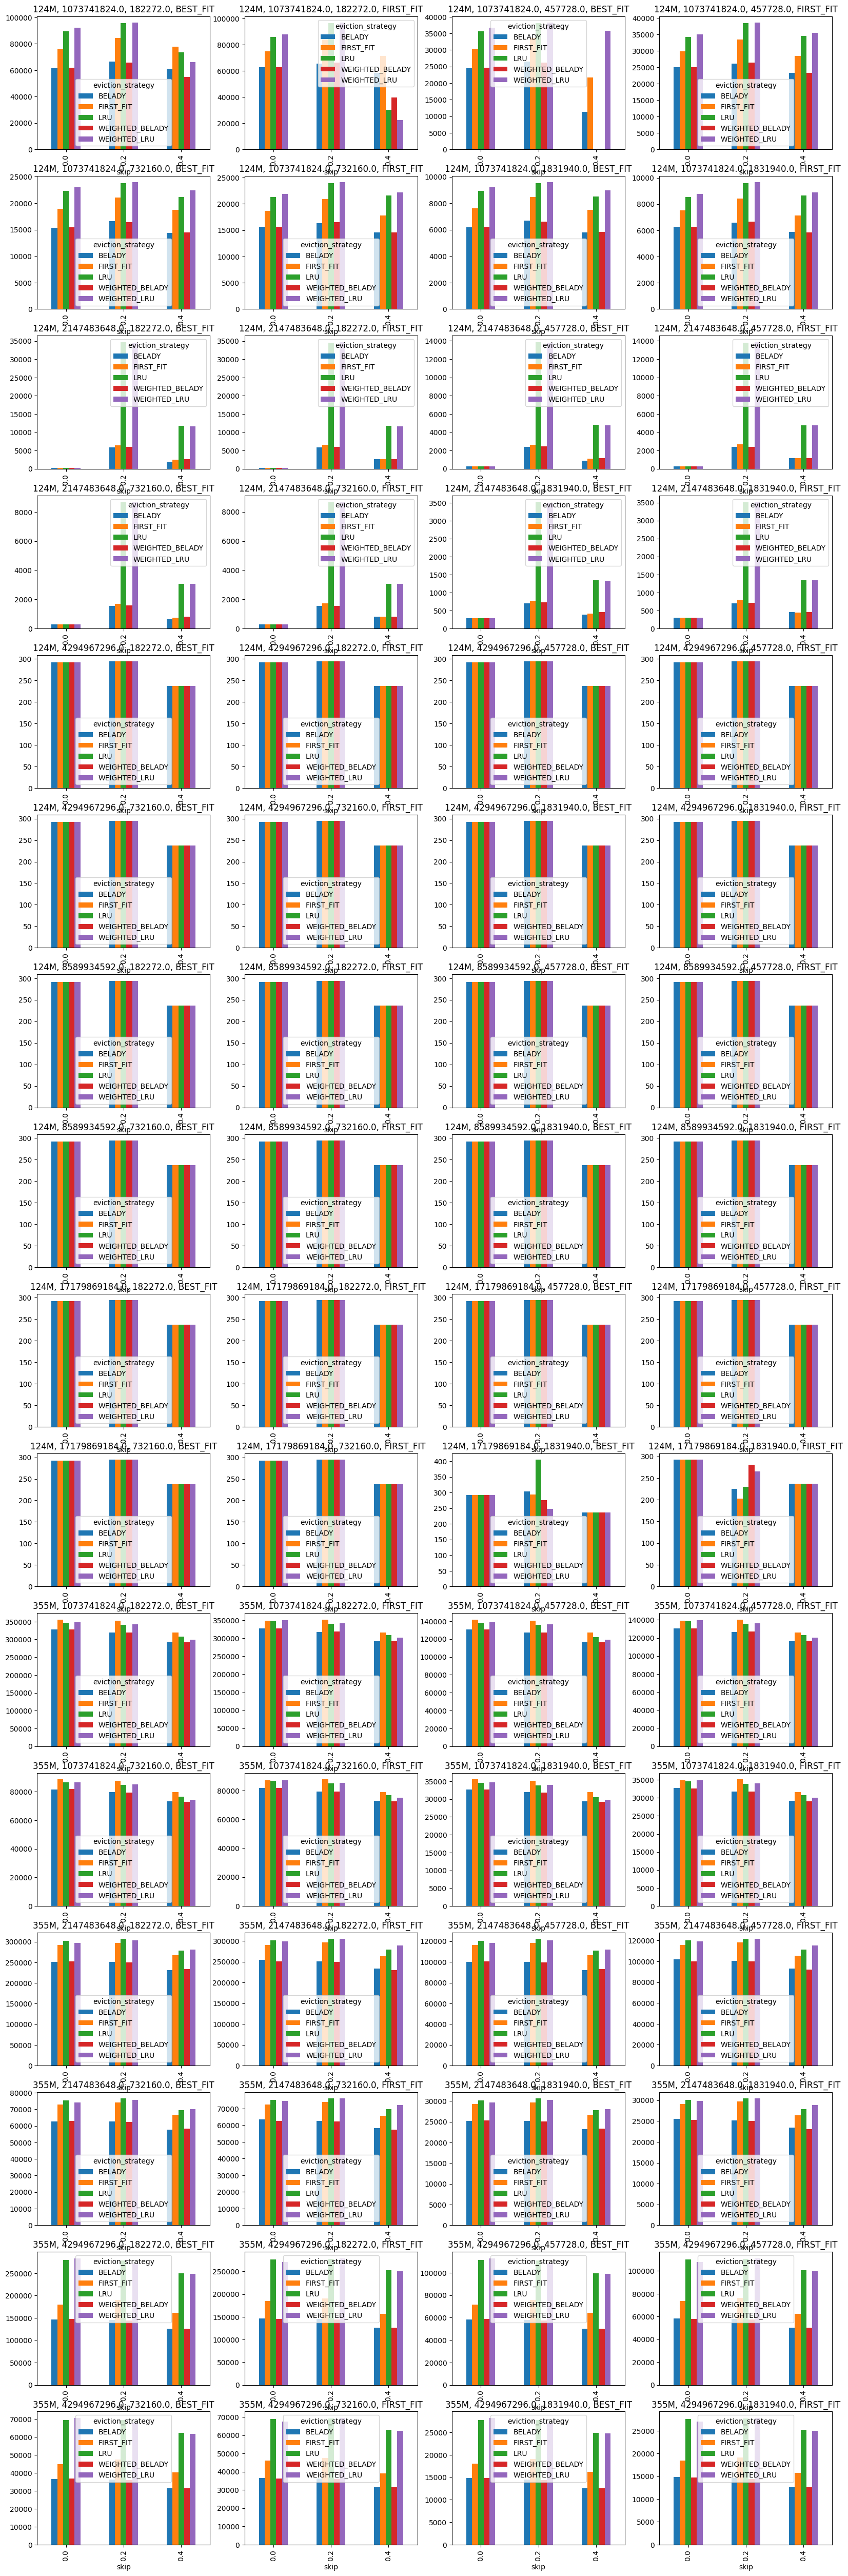

In [121]:
fig, axes = plt.subplots(16,4,figsize=(20,64))
for ((model_size, mem_limit, bandwidth, allocation_strategy), group), ax in zip(data.groupby(['model_size', 'mem_limit', 'bandwidth', 'allocation_strategy']), axes.flatten()):
    # try: 
        # Assuming 'group' is your DataFrame and 'bandwidth' is the column you want to plot
    group = group.sort_values('eviction_strategy')
    group = group.set_index(['skip', 'eviction_strategy'])['total_time'].unstack()
    group.plot.bar(ax=ax, title=f'{model_size}, {mem_limit}, {bandwidth}, {allocation_strategy}')

In [14]:
data['bandwidth'].value_counts()

bandwidth
26.2    432
6.6     432
13.1    432
39.3    432
19.7    432
32.7    432
Name: count, dtype: int64

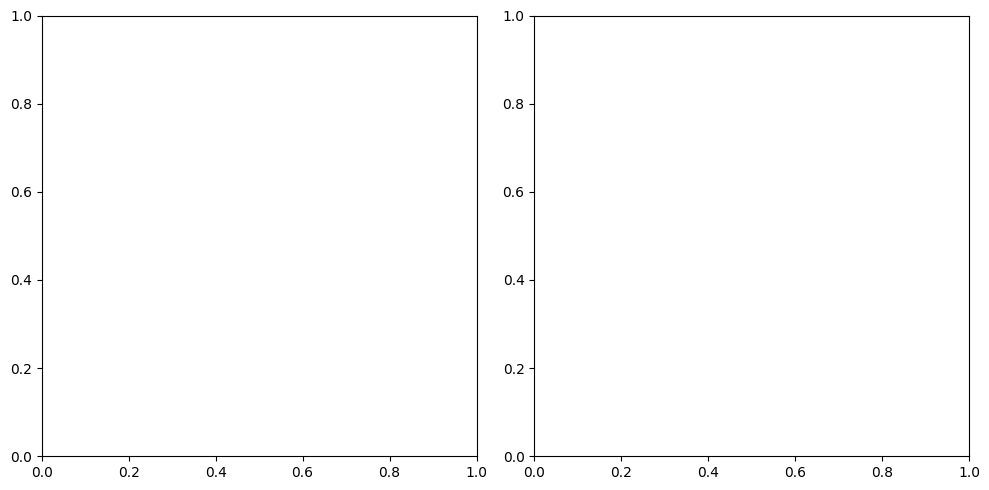

In [30]:
fig, axes = plt.subplots(1,2,figsize=(10,5), tight_layout = True)

In [45]:
strategy_data = data[(data['total_time'] > 0 )& (data['model_size'] == '774M') & (data['mem_limit'] == 8.0) & (data['bandwidth'] == (26.2)) & (data['eviction_strategy'] != 'FIRST_FIT')] 
strategy_data = strategy_data.set_index(['model_size', 'mem_limit', 'bandwidth', 'skip', 'allocation_strategy', 'eviction_strategy'])['total_time'].unstack()
strategy_data = strategy_data.T 
strategy_data 
strategy_data['geomean'] = strategy_data.apply(lambda x: x.prod()**(1/len(x)), axis=1)
ax = axes[0]
strategy_data['geomean'].plot.bar(ax = ax, rot=30)
ax.set_xlabel('Eviction Strategy\na)', fontsize = 14)
ax.set_ylabel('Total Time(ms)', fontsize = 14)
strategy_data['geomean']

eviction_strategy
BELADY              6876.891483
LRU                10658.509987
WEIGHTED_BELADY     6837.066090
WEIGHTED_LRU       10523.349302
Name: geomean, dtype: float64

In [46]:
res = strategy_data['geomean']
res = res / 10658.509987
res

eviction_strategy
BELADY             0.645202
LRU                1.000000
WEIGHTED_BELADY    0.641465
WEIGHTED_LRU       0.987319
Name: geomean, dtype: float64

In [47]:
strategy_data = data[(data['total_time'] > 0 )& (data['model_size'] == '774M') & (data['mem_limit'] == 8.0) & (data['bandwidth'] == (26.2))] 
strategy_data['duration(ms)'] = strategy_data['duration(ms)'].astype(float) / 1000 / 60
strategy_data = strategy_data.set_index(['model_size', 'mem_limit', 'bandwidth', 'skip', 'allocation_strategy', 'eviction_strategy'])['duration(ms)'].unstack()
strategy_data = strategy_data.T 
strategy_data 
strategy_data['geomean'] = strategy_data.apply(lambda x: x.prod()**(1/len(x)), axis=1)
ax = axes[1]
strategy_data['geomean'].plot.bar(ax = ax, rot=30)
ax.set_xlabel('Eviction Strategy\nb)', fontsize = 14)
ax.set_ylabel('Runtime (min)', fontsize = 14)
strategy_data['geomean']

/tmp/ipykernel_792796/3948946965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_data['duration(ms)'] = strategy_data['duration(ms)'].astype(float) / 1000 / 60


eviction_strategy
BELADY              81.174211
LRU                120.633086
WEIGHTED_BELADY     93.505519
WEIGHTED_LRU       121.732835
Name: geomean, dtype: float64

In [48]:
res = strategy_data['geomean']
res = res / 121.732835
res

eviction_strategy
BELADY             0.666823
LRU                0.990966
WEIGHTED_BELADY    0.768121
WEIGHTED_LRU       1.000000
Name: geomean, dtype: float64

In [49]:
res = 1/res
res

eviction_strategy
BELADY             1.499649
LRU                1.009116
WEIGHTED_BELADY    1.301879
WEIGHTED_LRU       1.000000
Name: geomean, dtype: float64

In [40]:
fig.savefig('eviction_strategy.pdf')
fig.savefig('eviction_strategy.png')